In [60]:

function velocityRS(x,y,s,F,delta, δs)
    
    u = zeros(2, length(s))
    int_u = zeros(size(u))
    r1 = zeros(size(x))
    r2 = zeros(size(y))
    F_dot_r = zeros(size(x))
    R2 = zeros(size(x))
    for i = 1:length(s)

        r1 .= x .- x[i]
        r2 .= y .- y[i]
        R2 .= r1 .^ 2 + r2 .^ 2
        F_dot_r .= (F[1, i] .* r1) .+ (F[2, i] .* r2)

        int_u[1, :] = (1 / (8 * pi)) * ((F[1, i] .* (R2 .+ 2 * delta^2)) ./ ((R2 .+ delta^2) .^ 1.5) .+ (F_dot_r .* (r1)) ./ ((R2 .+ delta^2) .^ 1.5))

        int_u[2, :] = (1 / (8 * pi)) * ((F[2, i] .* (R2 .+ 2 * delta^2)) ./ ((R2 .+ delta^2) .^ 1.5) .+ (F_dot_r .* (r2)) ./ ((R2 .+ delta^2) .^ 1.5))

        if i != 1 && i != length(s)
            u[1, :] = u[1, :] .+ (int_u[1, :]) * δs
            u[2, :] = u[2, :] .+ (int_u[2, :]) * δs
        else
            u[1, :] = u[1, :] .+ 0.5 * (int_u[1, :]) * δs
            u[2, :] = u[2, :] .+ 0.5 * (int_u[2, :]) * δs
        end
    end
    return u
end

velocityRS (generic function with 1 method)

In [62]:
#  @time begin
# import Pkg; Pkg.add("DifferentialEquations")
# import Pkg; Pkg.add("Plots")
# using ProfileView
using DifferentialEquations, Plots
# params = (S_T = 64,S_C = 12,L = 7,Amp = 0.55,N = 51, dt = 1e-4)

function RSFILL(S_T, S_C, L, Amp, N, t0, tmax, dt)

# S_T, S_C, L, Amp, N, dt = p
# S_T = 64;
# S_C = 12;
# L = 7;
# Amp = 0.55;
λ = 2.25 * π / L;


# N = 51;
δs = L / (N - 1);
s_range = (0.0, L);

δ = (2 / 3) * δs;
f(u, p, s) = sqrt(1 - Amp ^ 2 * λ ^ 2 * (cos(λ * s)) .^ 2)

x0 = 0;
prob = ODEProblem(f, x0, s_range)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat=δs)

y = Amp * sin.(λ * sol.t);


delta = (2 / 3) * δs;

s = sol.t
# x=zeros(size(s))
# y=zeros(size(s))
x = sol';
y = y';

k(ss, tt) = Amp * λ^2 * sin(λ * ss - 2 * pi * tt) / (sqrt(1 - Amp^2 * λ^2 * (cos(λ * ss - 2 * pi * tt))^2));

F = zeros(2, length(s));
# t = 0;

# dt = 1e-4;
# tmax = 1;
nmax = round((tmax -t0)/ dt);
anim=Animation()
for n = 1:nmax

    for i = 1:length(s)-1
        X_s = [x[i+1] .- x[i], y[i+1] .- y[i]]
        X_s_distance2 = (X_s[1] ^ 2 + X_s[2] ^ 2)
        F_t = -S_T * ((sqrt(X_s_distance2) / δs) - 1) * (X_s / (sqrt(X_s_distance2)))

        # F[1, i] = F[1, i] .- F_t[1]
        # F[1, i+1] = F[1, i+1] .+ F_t[1]
        # F[2, i] = F[2, i] .- F_t[2]
        # F[2, i+1] = F[2, i+1] .+ F_t[2]



        F[1, i] = F[1, i] - F_t[1]
        F[1, i+1] = F[1, i+1] + F_t[1]
        F[2, i] = F[2, i] - F_t[2]
        F[2, i+1] = F[2, i+1] + F_t[2]
    end

    for i = 2:length(s)-1
        κ = k.(s[i], t0)

        D2_x_i = (x[i+1] .- 2 * x[i] .+ x[i-1]) / (δs^2)
        D0_x_i = (x[i+1] .- x[i-1]) / (2 * δs)

        D2_y_i = (y[i+1] .- 2 * y[i] .+ y[i-1]) / (δs^2)
        D0_y_i = (y[i+1] .- y[i-1]) / (2 * δs)


        # F1 = S_C * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D0_y_i / δs)
        # F2 = -S_C * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D0_x_i / δs)
        # Q1 = -S_C * 0.5 * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D2_y_i)
        # Q2 = S_C * 0.5 * ((D2_x_i .* D0_y_i .- D0_x_i .* D2_y_i) .- κ) .* (D2_x_i)



        F1 = S_C * ((D2_x_i  * D0_y_i  - D0_x_i  * D2_y_i) - κ) * (D0_y_i / δs)
        F2 = -S_C * ((D2_x_i * D0_y_i - D0_x_i * D2_y_i) - κ) * (D0_x_i / δs)
        Q1 = -S_C * 0.5 * ((D2_x_i * D0_y_i - D0_x_i * D2_y_i) - κ) * (D2_y_i)
        Q2 = S_C * 0.5 * ((D2_x_i * D0_y_i - D0_x_i * D2_y_i) - κ) * (D2_x_i)


        # F[1, i+1] = F[1, i+1] .- F1 .- Q1
        # F[1, i] = F[1, i] .+ 2 * F1
        # F[1, i-1] = F[1, i-1] .- F1 .+ Q1

        # F[2, i+1] = F[2, i+1] .- F2 .- Q2
        # F[2, i] = F[2, i] .+ 2 * F2
        # F[2, i-1] = F[2, i-1] .- F2 .+ Q2



        F[1, i+1] = F[1, i+1] - F1 - Q1
        F[1, i] = F[1, i] + 2 * F1
        F[1, i-1] = F[1, i-1] - F1 + Q1

        F[2, i+1] = F[2, i+1] - F2 - Q2
        F[2, i] = F[2, i] .+ 2 * F2
        F[2, i-1] = F[2, i-1] - F2 + Q2
    end
   

    u=velocityRS(x,y,s,F,delta,δs);

    for i = 1:length(s)

        # x[i] = x[i] .+ dt * u[1, i]
        # y[i] = y[i] .+ dt * u[2, i]

        x[i] = x[i] + dt * u[1, i]
        y[i] = y[i] + dt * u[2, i]

    end

    t0 = t0 + dt

    if mod(n, 100) == 0

        plot(x', y', xlims=(0,L),ylims=(-1,1.5),aspect_ratio=:equal, legend=:false,marker=:circle,lw=3)
#     quiver!(x',y',quiver=(F[1,:]',F[2,:]'))

        annotate!(3, 1.25, "Time= $(rpad(round(t0; digits=2),4,"0")) s")
        frame(anim)

        #sleep(dt)

    end

end

vid=gif(anim, "anim_RS001.gif", fps = 10)
return vid
end


RSFILL (generic function with 3 methods)

[ Info: Saved animation to c:\Users\mosle\OneDrive - Tulane University\anim_RS001.gif


Plots.AnimatedGif("c:\\Users\\mosle\\OneDrive - Tulane University\\anim_RS001.gif")
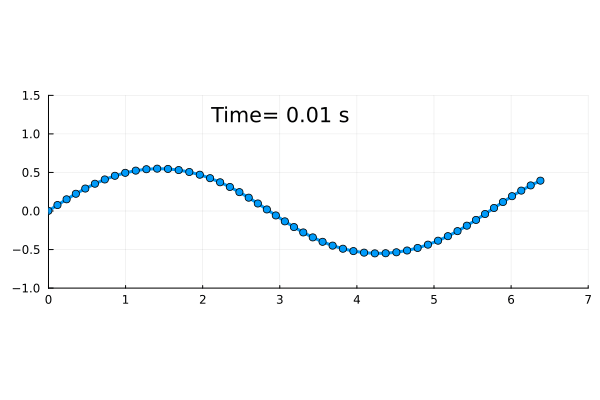

In [59]:
RSFILL(64,  12, 7,  0.55, 51,0,1, 1e-4)